In [1]:
import torch
import torch.nn as nn
from networks import DynamicUNet, LearnableScaleDynamicUNet

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import re
from utils import *

ids = [ re.findall("[0-9]+", name)[0] for name in os.listdir("./segmentation/patches") ]

rest, test = train_test_split(ids, test_size=20, random_state=42)
test_dataset = SegmentationDataset(test)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=12)

In [3]:
learning_rate = 1e-4
batch_size = 10
train_loss_fn = nn.CrossEntropyLoss()
valid_loss_fn = nn.CrossEntropyLoss(reduction="sum")
plateau_window = 5
scales = [1/8, 1/4, 1/2, 1]
n_runs = 10


losses = [ [ [] for _ in scales ] for _ in range(n_runs) ]
dice_scores = [ [ [] for _ in scales ] for _ in range(n_runs) ]
test_scores = []


for n in range(n_runs):
    network = LearnableScaleDynamicUNet(1, 2, [128, 256, 512], 8, [(64, 4), (32, 2), (16, 1)]).to(device)
    # network = DynamicUNet(1, 2, [128, 256, 512], 8, [(64, 4), (32, 2), (16, 1)]).to(device)

    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    for i, scale in enumerate(scales):
        train, validation = train_test_split(rest, test_size=20, random_state=42)

        train_dataset = SegmentationDataset(train, 1, 1)
        validation_dataset = SegmentationDataset(validation, 1, 1)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
        breakthrough = 999
        since = 0
        side = 128

        while since != plateau_window:
            # Training
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                x_hat = network(X)
                loss = train_loss_fn(x_hat, y)
                loss.backward()
                optimizer.step()
            # Validating
            with torch.no_grad():
                loss = 0
                dice_score_ = 0
                for X, y in validation_loader:
                    X, y = X.to(device,), y.to(device)
                    x_hat = network(X)
                    loss += valid_loss_fn(x_hat, y).item()
                    dice_score_ += dice_score(x_hat.cpu(), y.cpu(), reduction="sum")
                loss = loss / (len(validation_dataset) * side * side ) 
                dice_score_ = dice_score_ / len(validation_dataset)
                dice_scores[n][i].append(dice_score_)
                since += 1
                if loss < breakthrough:
                    breakthrough = loss
                    since=0
                print("Loss:", loss, "Dice score:", dice_score_, "N:", n)
                losses[n][i].append(loss)
        print("Epoch ended")
        network.use_higher_layer()
    # Testing
    with torch.no_grad():
        dice_score_ = 0
        for X, y in test_loader:
            X, y = X.to(device,), y.to(device)
            x_hat = network(X)
            dice_score_ += dice_score(x_hat.cpu(), y.cpu(), reduction="sum")
        dice_score_ = dice_score_ / len(test_dataset)
        test_scores.append(dice_score_)
        print(dice_score_)
    print("Run ended")

Loss: 0.4151212930679321 Dice score: 0.3863690853118896 N: 0
Loss: 0.244465172290802 Dice score: 0.7707535266876221 N: 0
Loss: 0.19414348006248475 Dice score: 0.8551664352416992 N: 0
Loss: 0.1445642590522766 Dice score: 0.8891286373138427 N: 0
Loss: 0.10485405325889588 Dice score: 0.8996224880218506 N: 0
Loss: 0.09430198669433594 Dice score: 0.9049350261688233 N: 0
Loss: 0.08478448987007141 Dice score: 0.9125678539276123 N: 0
Loss: 0.08136245310306549 Dice score: 0.9157172203063965 N: 0
Loss: 0.07791670858860016 Dice score: 0.9184722900390625 N: 0
Loss: 0.07783519625663757 Dice score: 0.9195637226104736 N: 0
Loss: 0.07472362220287324 Dice score: 0.923192834854126 N: 0
Loss: 0.0736101895570755 Dice score: 0.9252835750579834 N: 0
Loss: 0.07586605846881866 Dice score: 0.9253652572631836 N: 0
Loss: 0.07753823697566986 Dice score: 0.9253599166870117 N: 0
Loss: 0.07560392618179321 Dice score: 0.9266388416290283 N: 0
Loss: 0.07854099869728089 Dice score: 0.9260892391204834 N: 0
Loss: 0.079757

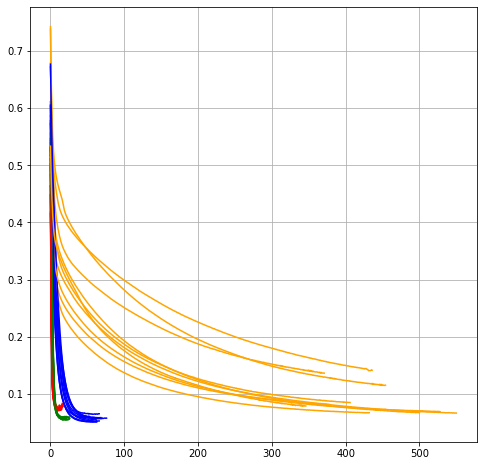

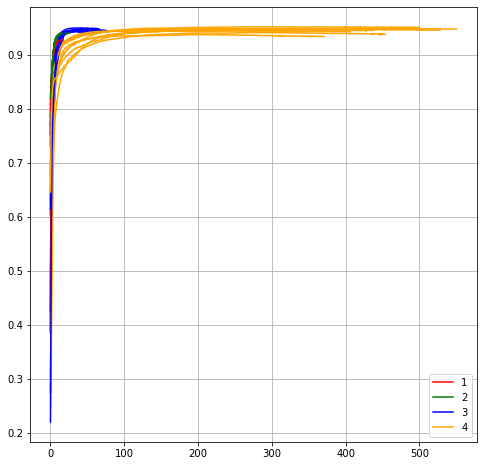

In [4]:
import matplotlib.pyplot as plt

colors = ["r", "g", "b", "orange"]

plt.figure(figsize=(8,8))
for run in losses:
    for loss, color in zip(run, colors):
        plt.plot(loss, color)
plt.grid()
plt.show()

plt.figure(figsize=(8,8))
for run in dice_scores:
    for dice, color in zip(run, colors):
        plt.plot(dice, color)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

In [5]:
postfix = "ls_fc"

with open("loss_val_"+postfix, "w") as file:
    for i, run in enumerate(losses):
        file.write("run {}\n".format(i))
        for j, model in enumerate(run):
            file.write("model {}\n".format(j))
            file.writelines([str(element)+"\n" for element in model])

with open("dice_val_"+postfix, "w") as file:
    for i, run in enumerate(dice_scores):
        file.write("run {}\n".format(i))
        for j, model in enumerate(run):
            file.write("model {}\n".format(j))
            file.writelines([str(element)+"\n" for element in model])

with open("dice_test_"+postfix, "w") as file:
    file.writelines([str(element)+"\n" for element in test_scores])

In [6]:
import re

def read_file(filename):
    with open(filename, "r") as file:
        for line in file.readlines()[2:]:
            if re.match("run", line) != None:
                yield "nr"
            elif re.match("model", line) != None:
                yield "nm"
            else:
                yield float(line)   

def parse(filename):
    file = read_file(filename)
    structure = []
    run_st = []
    model_st = []
    for read in file:
        if read == "nm":
            run_st.append(model_st)
            model_st = []
        elif read == "nr":
            structure.append(run_st)
            model_st = []
            run_st = []
        else:
            model_st.append(read)
    return structure

In [7]:
import numpy as np

structure = parse("dice_val_s")

final_scores = [run[-1][-1] for run in structure]
np.mean(final_scores)

0.9309632036421033